In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from prepare import clean_diabetic_data, data_split, select_kbest, rfe
from acquire import get_diabetic_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression 
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', 80)

In [2]:
df=clean_diabetic_data()

In [3]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test =  data_split(df, stratify_by='time_in_hospital')

In [4]:
train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((1712, 84),
 (735, 84),
 (612, 84),
 (1712, 83),
 (1712,),
 (735, 83),
 (735,),
 (612, 83),
 (612,))

In [5]:
train.head()

,race,gender,age,weight,time_in_hospital,insulin,race_AfricanAmerican,race_Asian,race_Caucasian,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight_>200,weight_[0-25),weight_[100-125),weight_[125-150),weight_[150-175),weight_[175-200),weight_[25-50),weight_[50-75),weight_[75-100),metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,...,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_No,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_No,tolbutamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,troglitazone_No,tolazamide_No,tolazamide_Steady,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67220310,Caucasian,Male,[80-90),[50-75),6,No,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1
373698290,Caucasian,Female,[70-80),[50-75),3,No,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1
121404990,Caucasian,Male,[70-80),[75-100),3,No,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1
108540414,Caucasian,Female,[60-70),[75-100),6,No,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1
46492332,Caucasian,Female,[70-80),[75-100),2,Steady,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,1,0,0,1,0,1,1,1,1,1


$H_0$: There is no difference in length of hospital stay between each race.

$H_a$: There is a significant difference in length of hospital stay based on race.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [6]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = " there is no difference in length of hospital stay between each race."

In [7]:
F, p = stats.f_oneway(train.time_in_hospital[train.race_AfricanAmerican == 1], train.time_in_hospital[train.race_Asian == 1], train.time_in_hospital[train.race_Caucasian == 1], train.time_in_hospital[train.race_Other == 1])
F, p

(0.3835495297503344, 0.7648757086166358)

In [8]:
if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that  there is no difference in length of hospital stay between each race.


Text(0.5, 1.0, 'Race v. Time in Hospital')

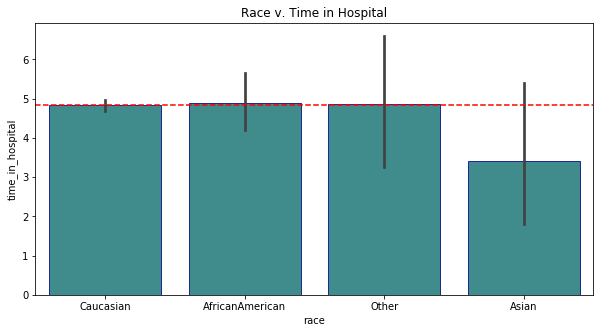

In [27]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.race, train.time_in_hospital, data=train, alpha=.8, color='teal', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Race v. Time in Hospital')

$H_0$: There is no difference in length of hospital stay between when changing insulin dose.

$H_a$: There is a significant difference in length of hospital stay when insulin dosage is increased.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [10]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = 'there is no difference in length of hospital stay between when changing insulin dose.'

In [11]:
F, p = stats.f_oneway(train.time_in_hospital[train.insulin_Down == 1], train.time_in_hospital[train.insulin_Up == 1], train.time_in_hospital[train.insulin_Steady== 1])
F, p

(1.9649100210567043, 0.1412713784906219)

In [12]:
if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that there is no difference in length of hospital stay between when changing insulin dose.


Text(0.5, 1.0, 'Insulin Dosage v. Time in Hospital')

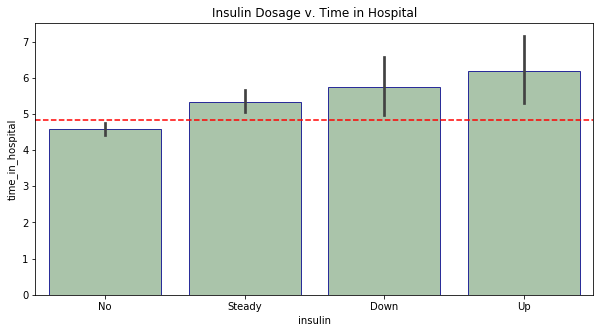

In [28]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.insulin, train.time_in_hospital, data=train, alpha=.8, color='darkseagreen', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Insulin Dosage v. Time in Hospital')

Text(0.5, 1.0, 'Age v. Time in Hospital')

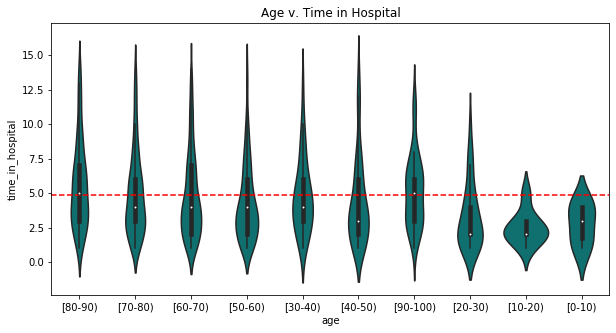

In [20]:
p = plt.figure(figsize=(10,5))
p = sns.violinplot(train.age, train.time_in_hospital, data=train, alpha=.8, color='teal', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Age v. Time in Hospital')

Text(0.5, 1.0, 'Weight v. Time in Hospital')

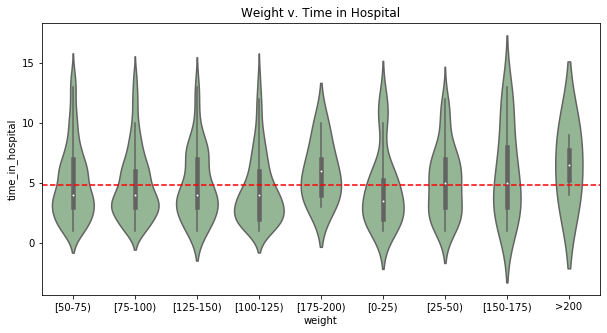

In [25]:
p = plt.figure(figsize=(10,5))
p = sns.violinplot(train.weight, train.time_in_hospital, data=train, alpha=.8, color='DarkSeaGreen', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Weight v. Time in Hospital')

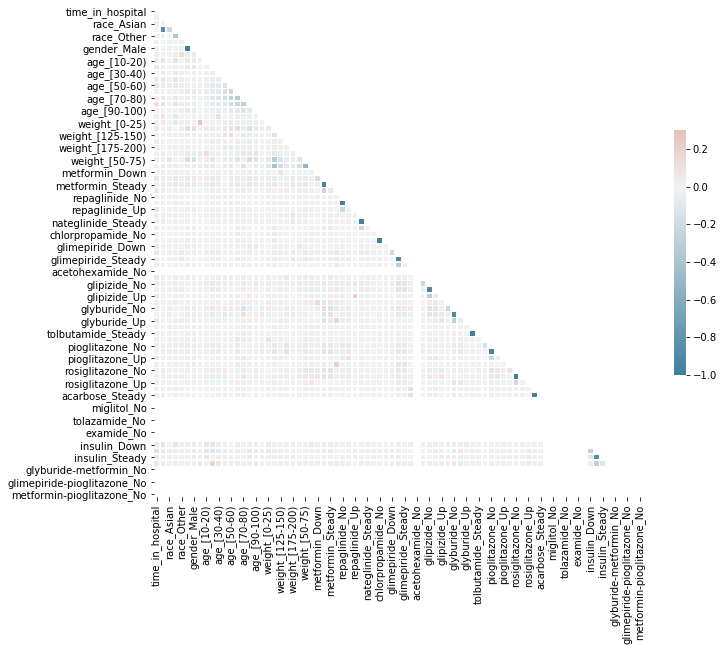

In [14]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})